In [482]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [483]:
m = 10          # 5, 50, 100, 500, 2000

In [484]:
train_size = 2000          # 100, 500, 2000, 10000

# Generate dataset

In [485]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


In [486]:
x = np.zeros((5000,2))

In [487]:
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [7,4],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [8,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [5.5,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [-1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [0,2],cov=[[0.1,0],[0,0.1]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [0,-1],cov=[[0.1,0],[0,0.1]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [0,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [-0.5,-0.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [0.4,0.2],cov=[[0.1,0],[0,0.1]],size=sum(idx[9]))

In [488]:
x[idx[0]][0], x[idx[5]][5] 

(array([7.14957125, 3.78451422]), array([0.87756167, 0.00457805]))

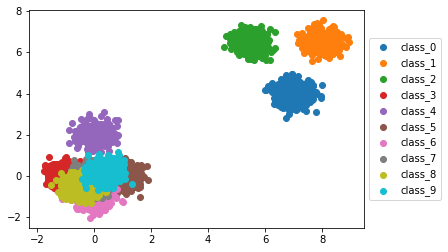

In [489]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [490]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(3513,)

In [491]:
np.unique(bg_idx).shape

(3513,)

In [492]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [493]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[-1.04275003e-16,  6.74571889e-17]]),
 array([[2.02981967, 1.63582644]]))

In [494]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [495]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1.]]), array([[4.89756643, 3.00501566]]))

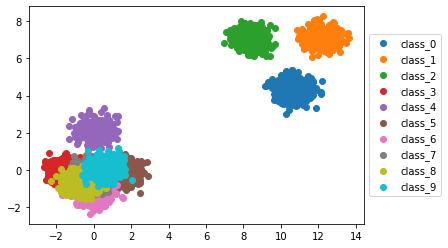

In [496]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [497]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [498]:
fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,m)
train_data=[]
a = []
fg_instance = np.array([[0.0,0.0]])
bg_instance = np.array([[0.0,0.0]])

for i in range(m):
  if i == fg_idx:
    b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
    fg_instance += x[b]
    a.append(x[b])
    print("foreground "+str(fg_class)+" present at " + str(fg_idx))
  else:
    bg_class = np.random.randint(3,10)
    b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
    bg_instance += x[b]
    a.append(x[b])
    print("background "+str(bg_class)+" present at " + str(i))

a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 5 present at 0
background 6 present at 1
foreground 2 present at 2
background 5 present at 3
background 3 present at 4
background 5 present at 5
background 7 present at 6
background 6 present at 7
background 5 present at 8
background 3 present at 9
(10, 2)
2 2


In [499]:
a

array([[ 1.52560273, -0.1298488 ],
       [-0.4226508 , -1.2003313 ],
       [ 8.5153438 ,  7.02349438],
       [ 2.09728368, -0.24465132],
       [-0.98608769, -0.75123246],
       [ 1.37297554, -0.37673308],
       [-0.88469208, -0.11155199],
       [ 0.32308641, -1.23774128],
       [ 1.37297554, -0.37673308],
       [-1.37994224, -0.01869277]])

In [500]:
fg_instance

array([[8.5153438 , 7.02349438]])

In [501]:
bg_instance

array([[ 3.01855109, -4.44751607]])

In [502]:
(fg_instance+bg_instance)/m , m

(array([[1.15338949, 0.25759783]]), 10)

In [503]:
# mosaic_list_of_images =[]
# mosaic_label = []
train_label=[]
fore_idx=[]
train_data = []
for j in range(train_size):
  np.random.seed(j)
  fg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])
  bg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])
  # a=[]

  for i in range(m):
    if i == fg_idx:
      fg_class  = np.random.randint(0,3)
      b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
      fg_instance += x[b]
      # a.append(x[b])
      # print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
      bg_class = np.random.randint(3,10)
      b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
      bg_instance += x[b]
      # a.append(x[b])
      # print("background "+str(bg_class)+" present at " + str(i))
  train_data.append((fg_instance+bg_instance)/m)
  # a = np.concatenate(a,axis=0)
  # mosaic_list_of_images.append(np.reshape(a,(2*m,1)))
  train_label.append(fg_class)
  fore_idx.append(fg_idx)

In [504]:
 train_data[0], train_label[0]

(tensor([[1.4207, 0.6244]], dtype=torch.float64), 1)

In [505]:
train_data = torch.stack(train_data, axis=0)
train_data.shape, len(train_label)

(torch.Size([2000, 1, 2]), 2000)

In [506]:
test_label=[]
# fore_idx=[]
test_data = []
for j in range(1000):
  np.random.seed(j)
  fg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])

  fg_class  = np.random.randint(0,3)
  b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
  fg_instance += x[b]
  # a.append(x[b])
  # print("foreground "+str(fg_class)+" present at " + str(fg_idx))

  test_data.append((fg_instance)/m)
  # a = np.concatenate(a,axis=0)
  # mosaic_list_of_images.append(np.reshape(a,(2*m,1)))
  test_label.append(fg_class)
  # fore_idx.append(fg_idx)

In [507]:
test_data[0], test_label[0]

(tensor([[1.1141, 0.3917]], dtype=torch.float64), 0)

In [508]:
test_data = torch.stack(test_data, axis=0)
test_data.shape, len(test_label)

(torch.Size([1000, 1, 2]), 1000)

In [509]:
x1 = (train_data).numpy()
y1 = np.array(train_label)

In [510]:
x1[y1==0,0]

array([[ 1.64409852,  0.6574221 ],
       [ 1.59567835,  0.38503995],
       [ 1.5244532 ,  0.51492166],
       ...,
       [ 0.80458843, -0.26032261],
       [ 0.78455135, -0.14641313],
       [ 1.64206709,  0.36480498]])

In [511]:
x1[y1==0,0][:,0]

array([1.64409852, 1.59567835, 1.5244532 , 1.34750211, 1.29346551,
       1.24226659, 1.29906122, 1.27040982, 0.71454345, 1.13927327,
       1.01764497, 1.32741653, 1.01514941, 0.92994903, 1.09051768,
       1.36629032, 1.27281836, 0.90857024, 1.09926047, 1.07879535,
       1.37486133, 0.51498465, 1.04730585, 1.02883756, 0.89114187,
       1.05482101, 1.08260383, 1.28094735, 0.98632698, 1.02557771,
       1.65651263, 0.95319902, 0.8609072 , 1.46504914, 1.92318691,
       1.27274322, 0.80375883, 1.5361008 , 1.24677344, 1.21051362,
       0.79065441, 0.90496736, 1.47687137, 1.61192396, 0.71244753,
       1.28941517, 1.64602342, 0.99390263, 1.49256293, 1.03185548,
       1.16511101, 1.03683067, 1.0052365 , 0.78362373, 0.98922597,
       0.75346443, 1.35056894, 0.7527622 , 1.08520894, 1.17924837,
       1.30344388, 0.48969529, 1.17011911, 0.88802729, 0.95309258,
       1.6123985 , 0.54984721, 0.96843228, 1.00613553, 1.14984416,
       0.9721766 , 0.39980437, 0.90656204, 1.41550044, 1.01863

In [512]:
x1[y1==0,0][:,1]

array([ 6.57422101e-01,  3.85039947e-01,  5.14921659e-01,  8.36495714e-01,
        2.25741546e-01,  2.29803864e-01,  4.33626428e-01,  1.42427597e-01,
        6.33377343e-02,  5.06940747e-01,  5.07279108e-01,  9.98313126e-01,
        2.78872223e-01,  1.20224718e+00,  4.89360630e-01,  9.95096356e-02,
        1.86829614e-01,  6.54286386e-01,  2.49572308e-01,  9.59368508e-01,
        1.05800480e+00,  4.99618807e-01,  8.04190289e-01,  1.27943014e-01,
        4.06058109e-01,  5.04619612e-01,  7.01083985e-01,  5.18101743e-01,
        2.88442993e-01, -1.15133376e-02,  3.94892842e-01,  2.22432143e-01,
        4.28958731e-01,  4.41103433e-01, -2.16998185e-02,  4.79888050e-01,
        5.61978069e-01,  5.27882665e-01,  3.29882583e-01,  8.85996700e-02,
        9.77513638e-01,  1.19272936e-01,  3.95775046e-01,  1.08771315e+00,
        1.20012231e+00,  7.17977916e-01,  8.08704303e-01,  8.42462187e-01,
        8.27455500e-01,  1.40264002e+00,  8.56146941e-01,  2.48327025e-01,
        5.89171276e-01,  

Text(0.5, 1.0, 'dataset4 CIN with alpha = 1/10')

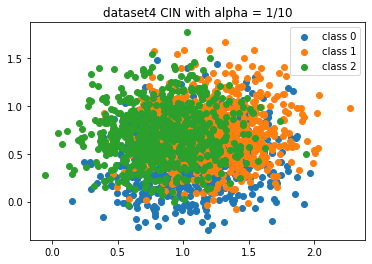

In [513]:
x1 = (train_data).numpy()
y1 = np.array(train_label)

plt.scatter(x1[y1==0,0][:,0], x1[y1==0,0][:,1], label='class 0')
plt.scatter(x1[y1==1,0][:,0], x1[y1==1,0][:,1], label='class 1')
plt.scatter(x1[y1==2,0][:,0], x1[y1==2,0][:,1], label='class 2')
plt.legend()
plt.title("dataset4 CIN with alpha = 1/"+str(m))

Text(0.5, 1.0, 'test dataset4')

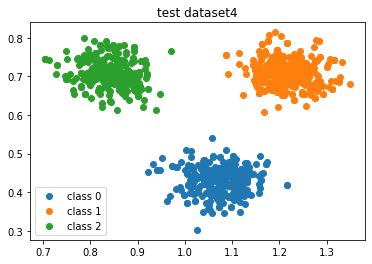

In [514]:
x1 = (test_data).numpy()
y1 = np.array(test_label)

plt.scatter(x1[y1==0,0][:,0], x1[y1==0,0][:,1], label='class 0')
plt.scatter(x1[y1==1,0][:,0], x1[y1==1,0][:,1], label='class 1')
plt.scatter(x1[y1==2,0][:,0], x1[y1==2,0][:,1], label='class 2')
plt.legend()
plt.title("test dataset4")

In [515]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [516]:
train_data[0].shape, train_data[0]

(torch.Size([1, 2]), tensor([[1.4207, 0.6244]], dtype=torch.float64))

In [517]:
batch = 200

traindata_1 = MosaicDataset(train_data, train_label )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)


In [518]:
testdata_1 = MosaicDataset(test_data, test_label )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)


In [519]:
# testdata_11 = MosaicDataset(test_dataset, labels )
# testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)

In [520]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,50)
        self.linear2 = nn.Linear(50,3)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = (self.linear2(x))

        return x[:,0]

In [521]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      # print(outputs.shape)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/(i+1)

In [522]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the %d test dataset %d: %.2f %%' % (total, number , 100 * correct / total))

In [523]:
def train_all(trainloader, ds_number, testloader_list, lr_list):
  
  final_loss = []
  for LR in lr_list:    
    print("--"*20, "Learning Rate used is", LR)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=0.001 ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1000
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            # print(outputs.shape)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%200 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d train images: %.2f %%' % (total,  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    final_loss.append(loss_curi) 
  return final_loss
    

In [524]:
train_loss_all=[]

testloader_list= [ testloader_1]
lr_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5 ]

In [525]:
fin_loss = train_all(trainloader_1, 1, testloader_list, lr_list)
train_loss_all.append(fin_loss)

---------------------------------------- Learning Rate used is 0.0001
epoch: [0 ] loss: 1.083
epoch: [1] loss: 1.076
epoch: [201] loss: 0.903
epoch: [401] loss: 0.902
epoch: [601] loss: 0.902
epoch: [801] loss: 0.902
Finished Training
Accuracy of the network on the 2000 train images: 57.75 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  998 total  1000
Accuracy of the network on the 1000 test dataset 1: 99.80 %
--------------------------------------------------------------------------------
---------------------------------------- Learning Rate used is 0.0005
epoch: [0 ] loss: 1.083
epoch: [1] loss: 1.076
epoch: [201] loss: 0.903
epoch: [401] loss: 0.902
epoch: [601] loss: 0.902
epoch: [801] loss: 0.902
Finished Training
Accuracy of the network on the 2000 train images: 57.75 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  998 total  1000
Accuracy of the network on the 1000 test dataset 1: 99.80 %
---------------------------------------------------------------------------

In [526]:
%matplotlib inline

In [527]:
len(fin_loss)

8

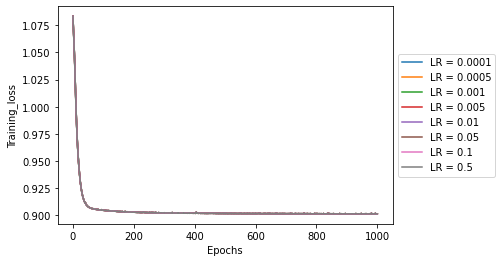

In [528]:
for i,j in enumerate(fin_loss):
    plt.plot(j,label ="LR = "+str(lr_list[i]))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))